<a href="https://colab.research.google.com/github/Farhan-Ali2002/Tajweed-Mentor/blob/master/datasettajweed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install keras_tuner

In [ ]:
from IPython.display import Audio, display
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import keras_tuner as kt
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt



In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset_path = '/content/gdrive/MyDrive/tajweed mentor backend/tajweed mentor backend/tajweed_mfcc_dataset.csv' #qalandar path
#dataset_path = '/content/gdrive/MyDrive/tajweed mentor backend/tajweed_mfcc_dataset.csv'

In [ ]:
# Load the MFCC dataset
df = pd.read_csv(dataset_path)

# Split features and labels
X = df.iloc[:, :-1].values  # Select all columns except the last one for X
y = df.iloc[:, -1].values  # Select only the last column for y

# Convert labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hypermodel with hyperparameters as arguments
def create_model(hp):
    filters = hp.Int('filters', min_value=32, max_value=256, step=32)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=2)
    epochs = hp.Int('epochs', min_value=10, max_value=20, step=5)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the tuner and search space
tuner = kt.Hyperband(create_model,
                      objective='val_accuracy',
                      max_epochs=20)

# Train the model with hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models()[0]

# Evaluate the best model
y_pred = np.argmax(best_model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Best Model:", accuracy)

# Print classification report (optional)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Reloading Tuner from ./untitled_project/tuner0.json
3/3 [==============================] - 0s 47ms/step
Accuracy of Best Model: 0.9210526315789473
                               precision    recall  f1-score   support

                        heavy       1.00      1.00      1.00         7
                       idgham       0.80      1.00      0.89         4
izhaar-e-halka(tanween hamza)       0.75      0.60      0.67         5
                laam_shimsiya       1.00      1.00      1.00         8
                      no_rule       0.87      0.87      0.87        15
                      qalqala       0.94      0.97      0.95        31
       silaate_sughra_wowmadd       1.00      0.83      0.91         6

                     accuracy                           0.92        76
                    macro avg       0.91      0.90      0.90        76
                 weighted avg       0.92      0.92      0.92        76



In [ ]:
 def calculate_avg_recitation_time(folder_path = "/content/gdrive/MyDrive/tajweed mentor backend/tajweed mentor backend/ikhlas"):

    total_duration = 0
    num_files = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            audio_path = os.path.join(folder_path, filename)

            y, sr = librosa.load(audio_path)
            duration = librosa.get_duration(y=y, sr=sr)

            total_duration += duration
            num_files += 1

    # Calculate average duration
    if num_files > 0:
        average_duration = total_duration / num_files
        return average_duration
    else:
        print("No audio files found in the folder.")
        return 0



In [ ]:
def calculate_avg_audio_duration(rules_folder_path="/content/gdrive/MyDrive/tajweed mentor backend/tajweed mentor backend/ikhlas/rules"):

    total_duration = 0
    num_files = 0


    for rule_folder in os.listdir(rules_folder_path):
        rule_folder_path = os.path.join(rules_folder_path, rule_folder)


        if not os.path.isdir(rule_folder_path):
            continue


        for filename in os.listdir(rule_folder_path):
            if filename.endswith(".wav"):
                audio_path = os.path.join(rule_folder_path, filename)


                y, sr = librosa.load(audio_path)
                duration = librosa.get_duration(y=y, sr=sr)


                total_duration += duration
                num_files += 1

    # Calculate average duration
    if num_files > 0:
        avg_duration = total_duration / num_files

        return avg_duration
    else:
        print("No audio files found in the rules folder.")
        return 0



In [ ]:
###################### Scaling #####################################


def preprocessing_features_extraction(audio_file):

    y, sr = librosa.load(audio_file)
    target_num_mfccs = 10
    user_duration = librosa.get_duration(y=y, sr=sr)


    avg_win_size = calculate_avg_audio_duration()
    average_duration= calculate_avg_recitation_time()
    # Scaled window size
    window_size = avg_win_size *(user_duration/average_duration)
    print("Window size=",window_size,"\n TimeTaken=",user_duration)
    # Convert window size to hop_length (number of samples)
    hop_lengthh = int(window_size * sr)

    # Calculate the number of segments
    num_segments = int(np.ceil(len(y) / hop_lengthh))

    # Initialize a list to store the segment boundaries
    segment_boundaries = [0]
    mfccs_list = []

    # Compute segment boundaries
    for i in range(num_segments):
        segment_start = i * hop_lengthh
        segment_end = min(segment_start + hop_lengthh, len(y))
        segment_boundaries.append(segment_end)
        segment = y[segment_start:segment_end]
        hop_length = len(segment) // (target_num_mfccs + 1)
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, hop_length=hop_length)

        # Append MFCCs to the list
        mfccs_list.append(mfccs)

    # Reshape each MFCC segment and accumulate them into reshaped_mfcc
    reshaped_mfcc = []
    for mfcc_segment in mfccs_list:
        flattened_mfcc = mfcc_segment.flatten()
        reshaped_input = flattened_mfcc.reshape(1, flattened_mfcc.shape[0], 1)
        reshaped_mfcc.append(reshaped_input)

    return reshaped_mfcc


In [ ]:
# Load the audio file
audio_file = r"/content/gdrive/MyDrive/tajweed mentor backend/tajweed mentor backend/surahikhlas2.wav" #qalandar drive path
#audio_file = r"/content/gdrive/MyDrive/tajweed mentor backend/testingsurahikhlas.wav"

# mfccs_list = api_call()
mfccs_list = preprocessing_features_extraction(audio_file)



predicted_labels = []
# Now you can pass reshaped MFCCs through your trained model for prediction
for i, segment_mfcc in enumerate(mfccs_list):
    predictions = best_model.predict(segment_mfcc)
    # Post-processing (if needed)
    # For example, you can map predicted class indices to label names
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
    print(f"Segment {i+1} predicted label: {predicted_label}")
    predicted_labels.append(predicted_label[0])
print(predicted_labels)

Window size= 0.7730631035317855 
 TimeTaken= 11.50390022675737
1/1 [==============================] - 0s 190ms/step
Segment 1 predicted label: ['no_rule']
1/1 [==============================] - 0s 36ms/step
Segment 2 predicted label: ['heavy']
1/1 [==============================] - 0s 38ms/step
Segment 3 predicted label: ['qalqala']
1/1 [==============================] - 0s 37ms/step
Segment 4 predicted label: ['no_rule']
1/1 [==============================] - 0s 35ms/step
Segment 5 predicted label: ['heavy']
1/1 [==============================] - 0s 39ms/step
Segment 6 predicted label: ['qalqala']
1/1 [==============================] - 0s 41ms/step
Segment 7 predicted label: ['izhaar-e-halka(tanween hamza)']
1/1 [==============================] - 0s 42ms/step
Segment 8 predicted label: ['qalqala']
1/1 [==============================] - 0s 37ms/step
Segment 9 predicted label: ['qalqala']
1/1 [==============================] - 0s 33ms/step
Segment 10 predicted label: ['qalqala']
1/1 [==

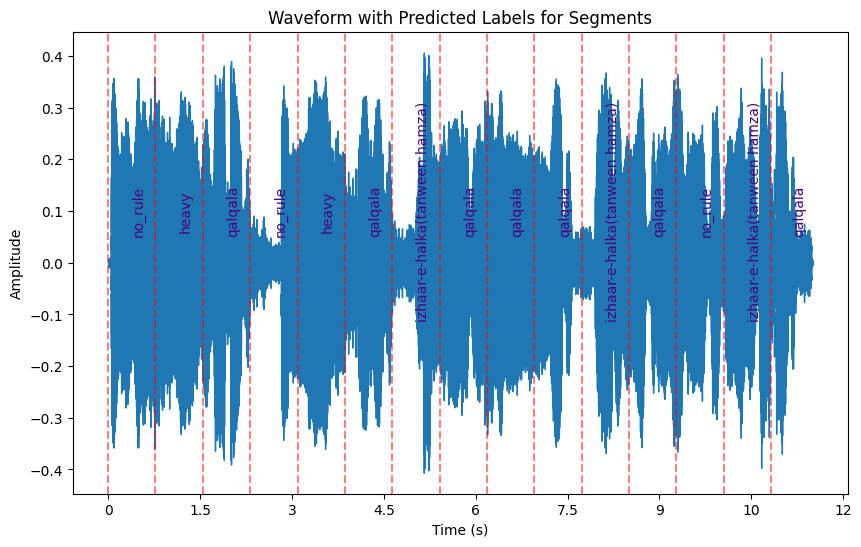

In [ ]:
y, sr = librosa.load(audio_file)

user_duration = librosa.get_duration(y=y, sr=sr)
avg_win_size = calculate_avg_audio_duration()
average_duration= calculate_avg_recitation_time()


window_size = avg_win_size *(user_duration/average_duration)


# Convert window size to hop_length (number of samples)
hop_lengthh = int(window_size * sr)

# Calculate the number of segments
num_segments = int(np.ceil(len(y) / hop_lengthh))

plt.figure(figsize=(10, 6))
librosa.display.waveshow(y, sr=sr)

segment_boundaries = [0]
# Plot segment boundaries with predicted labels
for i in range(num_segments):
    segment_start = i * hop_lengthh
    segment_end = min(segment_start + hop_lengthh, len(y))
    segment_boundaries.append(segment_end)

for i in range(num_segments):
    segment_start = segment_boundaries[i] / sr
    segment_end = segment_boundaries[i+1] / sr
    segment_mid = (segment_start + segment_end) / 2
    label_y = 0.1  # Adjust the vertical position of labels

    # Rotate the text vertically
    plt.text(segment_mid, label_y, predicted_labels[i], rotation=90, verticalalignment='center', fontsize=10, color='indigo')
    plt.axvline(x=segment_start, color='r', linestyle='--', alpha=0.5)

plt.title('Waveform with Predicted Labels for Segments')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
# Function to play audio segment
def play_audio_segment(segment, sr):
    return Audio(data=segment, rate=sr)

# Iterate through predicted labels and segment boundaries
for i, label in enumerate(predicted_labels):
    segment_start_time = segment_boundaries[i] / sr
    segment_end_time = segment_boundaries[i + 1] / sr
    segment_audio = y[int(segment_start_time * sr):int(segment_end_time * sr)]

    print(f"Segment {i+1} - Label: {label}")
    display(play_audio_segment(segment_audio, sr))


Segment 1 - Label: no_rule


Segment 2 - Label: heavy


Segment 3 - Label: qalqala


Segment 4 - Label: no_rule


Segment 5 - Label: heavy


Segment 6 - Label: qalqala


Segment 7 - Label: izhaar-e-halka(tanween hamza)


Segment 8 - Label: qalqala


Segment 9 - Label: qalqala


Segment 10 - Label: qalqala


Segment 11 - Label: izhaar-e-halka(tanween hamza)


Segment 12 - Label: qalqala


Segment 13 - Label: no_rule


Segment 14 - Label: izhaar-e-halka(tanween hamza)


Segment 15 - Label: qalqala


In [ ]:
# Initialize variables to store segment timestamps and labels in order
segment_timestamps_dict = {}
ordered_labels = []

# Counter for assigning unique numbers to labels
label_count = 0

# Calculate start and end times for each segment
for i, label in enumerate(predicted_labels):
    segment_start_time = segment_boundaries[i] / sr
    segment_end_time = segment_boundaries[i + 1] / sr if i + 1 < len(segment_boundaries) else time_duration



    new_label = f"{label}_{label_count}"
    label_count += 1
    segment_timestamps_dict[new_label] = [(segment_start_time, segment_end_time)]
    ordered_labels.append(new_label)  # Keep track of the order of labels


# Print the dictionary with labels in order
print(segment_timestamps_dict)


{'no_rule_0': [(0.0, 0.773061224489796)], 'heavy_1': [(0.773061224489796, 1.546122448979592)], 'qalqala_2': [(1.546122448979592, 2.3191836734693876)], 'no_rule_3': [(2.3191836734693876, 3.092244897959184)], 'heavy_4': [(3.092244897959184, 3.8653061224489798)], 'qalqala_5': [(3.8653061224489798, 4.638367346938775)], 'izhaar-e-halka(tanween hamza)_6': [(4.638367346938775, 5.411428571428571)], 'qalqala_7': [(5.411428571428571, 6.184489795918368)], 'qalqala_8': [(6.184489795918368, 6.957551020408164)], 'qalqala_9': [(6.957551020408164, 7.7306122448979595)], 'izhaar-e-halka(tanween hamza)_10': [(7.7306122448979595, 8.503673469387754)], 'qalqala_11': [(8.503673469387754, 9.27673469387755)], 'no_rule_12': [(9.27673469387755, 10.049795918367346)], 'izhaar-e-halka(tanween hamza)_13': [(10.049795918367346, 10.822857142857142)], 'qalqala_14': [(10.822857142857142, 11.50390022675737)]}


In [ ]:
# Reference label list
label_list = [
    "no_rule_0", "heavy_1", "qalqala_2", "no_rule_3", "laam_shimsiya_4", "no_rule_5", "qalqala_6",
    "qalqala_7", "no_rule_8", "idgham_9", "izhaar-e-halka(tanween hamza)_10", "qalqala_11", "no_rule_12","izhaar-e-halka(tanween hamza)_13","qalqala_14"
]
count=0
for key in segment_timestamps_dict.keys():
  if key != label_list[count]:
    print("The rule that was violated here is :",label_list[count],segment_timestamps_dict[key])
  count+=1





The rule that was violated here is : laam_shimsiya_4 [(3.092244897959184, 3.8653061224489798)]
The rule that was violated here is : no_rule_5 [(3.8653061224489798, 4.638367346938775)]
The rule that was violated here is : qalqala_6 [(4.638367346938775, 5.411428571428571)]
The rule that was violated here is : no_rule_8 [(6.184489795918368, 6.957551020408164)]
The rule that was violated here is : idgham_9 [(6.957551020408164, 7.7306122448979595)]


In [ ]:
# import librosa
# import librosa.display
# import sounddevice as sd

# # Load reference recording
# location=r"/content/gdrive/MyDrive/tajweed mentor backend/tajweed mentor backend/testingsurahikhlas.wav"#qalandar
# reference_audio, sample_rate = librosa.load(location, sr=None)

# # Define window size
# window_size = 0.74  # in seconds

# # Calculate hop length based on window size
# hop_length = int(window_size * sample_rate)

# # Segment the audio
# segments = []
# start_time = 0
# while start_time + hop_length < len(reference_audio):
#     end_time = start_time + hop_length
#     segments.append((start_time, end_time))
#     start_time += hop_length

# # Listen to each segment and annotate manually
# annotations = []
# for i, (start_time, end_time) in enumerate(segments):
#     segment = reference_audio[start_time:end_time]  # Extract segment from audio

#     # Play the segment
#     print(f"Listening to Segment {i + 1}: {start_time} - {end_time}")
#     sd.play(segment, sample_rate)
#     sd.wait()

#     # Prompt for Tajweed rule annotation
#     tajweed_rule = input("Enter Tajweed rule for this segment: ")
#     annotations.append({'start_time': start_time, 'end_time': end_time, 'tajweed_rule': tajweed_rule})

# # Save annotations to CSV file
# import pandas as pd
# df = pd.DataFrame(annotations)
# df.to_csv('annotations.csv', index=False)


In [ ]:
#### Dataset creation code

# import numpy as np
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import os
# import librosa

# # Define the root directory containing the folder hierarchy
# root_dir = r".\ikhlas"

# # Create an empty list to store data
# data = []
# target_num_mfccs = 10
# # Define the directory containing the rules
# rules_dir = os.path.join(root_dir, "rules")

# # Traverse through each folder inside the 'rules' directory
# for rule_folder in os.listdir(rules_dir):
#     if rule_folder == '.git':
#         continue
#     rule_folder_path = os.path.join(rules_dir, rule_folder)
#     print(rule_folder_path)

#     # Skip non-directory files
#     if not os.path.isdir(rule_folder_path):
#         continue

#     # Process audio samples in the current rule folder
#     for filename in os.listdir(rule_folder_path):
#         audio_path = os.path.join(rule_folder_path, filename)
#         audio_data, sr = librosa.load(audio_path)  # Load audio data
#         hop_length = len(audio_data) // (target_num_mfccs + 1)
#         mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13,hop_length=hop_length)  # Extract MFCCs

#         # Flatten MFCCs into a 1D array
#         flattened_mfccs = mfccs.flatten()
#         data.append((flattened_mfccs, rule_folder))  # Append data and label to list

# # Convert list to DataFrame
# df = pd.DataFrame(data, columns=['MFCC', 'Label'])

# # Convert MFCCs into a DataFrame
# mfcc_columns = [f'MFCC{i}' for i in range(df['MFCC'].iloc[0].shape[0])]
# mfcc_df = pd.DataFrame(df['MFCC'].to_list(), columns=mfcc_columns)

# # Concatenate the MFCC DataFrame with the original DataFrame
# df = pd.concat([df, mfcc_df], axis=1)

# # Drop the original MFCC column
# df.drop(columns=['MFCC'], inplace=True)

# # Reorder columns with labels as the last column
# columns = mfcc_columns + ['Label']
# df = df[columns]

# # Shuffle DataFrame if desired
# df = df.sample(frac=1).reset_index(drop=True)

# # Save DataFrame to CSV file
# df.to_csv("tajweed_mfcc_dataset.csv", index=False)
